In [41]:
cd ../..

D:\Users\mrefoyo


C:\Users\mrefoyo\miniconda3\envs\RL-CFE_39\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [42]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from experiments.evaluation.evaluation_utils import load_dataset_for_eval, calculate_metrics_for_dataset, calculate_metrics_for_dataset_mp

print(tf.__version__)

2.13.0


In [43]:
# DATASETS = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = [
    "BasicMotions", 
    "NATOPS", 
    "UWaveGestureLibrary",
    'Cricket', 
    'ArticularyWordRecognition', 
    'Epilepsy', 
    'PenDigits', 
    'PEMS-SF', 
    'RacketSports', 'SelfRegulationSCP1'
]

# MO_UTILITY = np.array([0.1, 0.32, 0.48, 0])
MO_UTILITY = np.array([0.1, 0.3, 0.4, 0.2])
model_to_explain = "inceptiontime_pytorch"
scaling = "standard"
osc_names = {"AE": "pytorch_ae_basic_train_scaling", "IF": "if_basic_train_scaling", "LOF": "lof_basic_train_scaling"}
methods = {
    # Comparison between single objective and multi objective ordered by same weights
    "comte": "COMTE",
    "abcf": "AB-CF",
    "discox": "DiscoX",
    # "d8387d902c6723a9106adc62d4fc6f327a8bd275": "Multi-SpaCE (naive_model)",
    # "d98ff072a62c4346b035510c421f3498e40f8bbc": "Multi-SpaCE ($p^p=0.5$)",
    "9a44107d8e21ee80fd70c72382c3389102ce1096": "Multi-SpaCE",

    # "_e8ff35cb894a2ee82c9c058d62b1072e075d3cc5": "FastPlaCE",
    # "_33d44533be1ce829aa6fde207c4d84f711d1517c": "FastPlaCE-Time",
    # "_07d2adc2159b396d62a2e1d8da6c8923893b388e": "FastPlaCE-Pla",
    # "_946b07beed9fefc0d76bf18de617b7c8b3f4d836": "FastPlaCE-Pla-block",
    "_cb3a3526f4a032a3bb4e19951eb7f203f8a40b32": "FastPACE",
    
    
}

# Get results

In [44]:
# Data and aux data dict
data_dict = {}
models_dict = {}
outlier_calculators_dict = {}
possible_nuns_dict = {}
desired_classes_dict = {}
original_classes_dict = {}

# Results dicts
mean_results_dict = {}
methods_cfs_dict = {}
results_all_datasets_df = pd.DataFrame()
common_test_indexes_dict = {}

# Iterate through datasets
for dataset in DATASETS:
    print(f'Calculating metrics for {dataset}')
    # Load all info needed to get the counterfactual
    data_tuple, original_classes, model_wrapper, outlier_calculators, possible_nuns, desired_classes = load_dataset_for_eval(dataset, model_to_explain, osc_names, scaling=scaling)
    data_dict[dataset] = data_tuple
    models_dict[dataset] = model_wrapper
    outlier_calculators_dict[dataset] = outlier_calculators
    possible_nuns_dict[dataset] = possible_nuns
    desired_classes_dict[dataset] = desired_classes
    original_classes_dict[dataset] = original_classes

    # Get the metrics for all methods
    dataset_mean_std_df, dataset_results_df, method_cfs_dataset, common_test_indexes = calculate_metrics_for_dataset(
        dataset, methods, model_to_explain,
        data_tuple, original_classes, model_wrapper, outlier_calculators, possible_nuns,
        mo_weights=MO_UTILITY
    )
    mean_results_dict[dataset] = dataset_mean_std_df
    methods_cfs_dict[dataset] = method_cfs_dataset
    results_all_datasets_df = pd.concat([results_all_datasets_df, dataset_results_df])
    common_test_indexes_dict[dataset] = common_test_indexes

    # Store results
    # dataset_mean_std_df.to_csv(f'./experiments/evaluation/results_mean_metrics_{dataset}.csv', sep=";", index=False)

# Store all results
# results_all_datasets_df.to_csv(f'./experiments/evaluation/results_all.csv', sep=";", index=False)


Calculating metrics for BasicMotions


FileNotFoundError: [Errno 2] No such file or directory: './experiments/data/UCR/BasicMotions/X_train.npy'

In [ ]:
from IPython.display import display
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset])

In [ ]:
columns = ["nchanges", "sparsity", "L2", "proba", "valid", "AE_IOS", "AE_OS", "IF_OS", "LOF_OS", "subsequences", "train_time", "times", "ImprovementOverNUN"]
for dataset in DATASETS:
    print(dataset)
    display(mean_results_dict[dataset].set_index("method").sort_index()[columns])

In [ ]:
import re

def split_mean_std(column):
    """Extract mean and std from columns with 'mean ± std' format."""
    means, stds = [], []
    for value in column:
        if isinstance(value, str):
            mean, std = map(float, re.split(r" ± ", value))
        else:
            mean, std = float('nan'), float('nan')  # Handle NaN cases
        means.append(mean)
        stds.append(std)
    return means, stds

In [ ]:
complete_results_df = pd.DataFrame()
for dataset in DATASETS:
    new_dataset_results = mean_results_dict[dataset]
    new_dataset_results['dataset'] = dataset
    complete_results_df = pd.concat([complete_results_df, new_dataset_results])

In [ ]:
# Applying the function to relevant columns to extract mean and std values
metrics = ['sparsity', 'L2', 'valid', "AE_OS", 
           "IF_OS", "LOF_OS", 
           'subsequences %', "subsequences", "times", "ImprovementOverNUN"]

for metric in metrics:
    mean_col, std_col = split_mean_std(complete_results_df[metric])
    complete_results_df[f"{metric}_mean"] = mean_col
    complete_results_df[f"{metric}_std"] = std_col

In [ ]:
# Calculate rank for each dataset
ranked_data = complete_results_df.copy()
for metric in metrics:
    if metric in ['valid', "ImprovementOverNUN"]: 
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=False, method='min')
    else:
        ranked_data[f"{metric}_rank"] = ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=True, method='min')

In [ ]:
pd.set_option('display.width', 500)
metric_pivots_df = {}
for metric in metrics:
    # Calculate metrics
    metric_pivot_df = complete_results_df.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_mean"],
        # aggfunc=lambda x: ''.join(x)
    )
    method_names = metric_pivot_df.columns.get_level_values(1)
    metric_pivot_df.columns = method_names
    metric_pivot_df.index.name = None
    metric_pivot_df.columns.name = None

    # Calculate average rankings
    ranked_pivot_df = ranked_data.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_rank"],
    )
    metric_pivot_df.loc["Average Rank"] = ranked_pivot_df.mean(axis=0).values
    
    print(metric)
    display(metric_pivot_df)
    metric_pivots_df[metric] = metric_pivot_df

In [ ]:
rename_method_dict = {"Multi-SpaCE ($p^p=0.75$)": 'Multi-SpaCE'}
rename_metric_dict = {
    "AE_IOS": "IOS(AE)", "IF_IOS": "IOS(IF)", "LOF_IOS": "IOS(LOF)",
    "AE_OS": "OS(AE)", "IF_OS": "OS(IF)", "LOF_OS": "OS(LOF)",
    "ImprovementOverNUN": "IoN"
}
rename_dataset_dict = {
    "ProximalPhalanxOutlineCorrect": "PPOC", "NonInvasiveFatalECGThorax2": "NI-ECG2",
    'ArticularyWordRecognition': "AWR", "SelfRegulationSCP1": "SR-SCP1", "UWaveGestureLibrary": "UWave"
}
dataset_order = [
    'AWR', "BasicMotions", 'Cricket', 'Epilepsy', 
    "NATOPS", 'PEMS-SF', 'PenDigits', 'RacketSports', 'SR-SCP1',
    "UWave",
]
method_order = [
    'NG', 'Glacier', 'COMTE', 'AB-CF', 'DiscoX', 'Multi-SpaCE', "FastPACE"
]

In [ ]:
# Create simple result tables
simple_metrics = ["sparsity", "L2", "valid", "subsequences", "subsequences %", "AE_OS", "IF_OS", "LOF_OS", "times"]
higher_is_better_metrics = ["valid", "ImprovementOverNUN"]

for metric, metric_pivot_df_orig in metric_pivots_df.items():
    if metric in simple_metrics:
        print(metric)
        metric_pivot_df = metric_pivot_df_orig.copy()
        # Order methods and datasets
        metric_pivot_df = metric_pivot_df.rename(columns=rename_method_dict, index=rename_dataset_dict)
        ordered_methods = [col for col in method_order if col in metric_pivot_df.columns]
        metric_pivot_df = metric_pivot_df[ordered_methods]
        ordered_datasets = [dataset for dataset in dataset_order if dataset in metric_pivot_df.index]
        metric_pivot_df = metric_pivot_df.loc[dataset_order + ["Average Rank"]]
        method_names = metric_pivot_df.columns

        # Create table header
        table_header_fixed = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{l|""" + "".join(["c"] * len(method_names)) + "}\n\\hline\n"

        table_columns = "Dataset & " + " & ".join(method_names) + " \\\\\n\hline\n"

        table_rows = []
        for dataset, row in metric_pivot_df.iterrows():
            if dataset == "Average Rank":
                table_rows.append("\hline")
            row_data = [dataset]
            # Extract numeric values and determine the best and second-best
            numeric_values = row[method_names].dropna()
            if (metric in higher_is_better_metrics) and (dataset != "Average Rank"):
                best_value = numeric_values.max()
                second_best_value = numeric_values.nlargest(2).iloc[-1]
            else:
                best_value = numeric_values.min()
                second_best_value = numeric_values.nsmallest(2).iloc[-1]
                
            for method in method_names:
                value = row[method]
                if pd.isna(value):
                    formatted_value = "-"
                else:
                    formatted_value = str(round(value, 2))
                    if value == best_value:
                        formatted_value = f"\\textbf{{{formatted_value}}}"
                    elif value == second_best_value:
                        formatted_value = f"\\underline{{{formatted_value}}}"
                row_data.append(formatted_value)
            table_rows.append(" & ".join(row_data) + " \\\\")

        table_footer = """
\\hline
\\end{tabular}
\\end{table}
"""
        latex_table = table_header_fixed + table_columns + "\n".join(table_rows) + table_footer
        print(latex_table)

In [ ]:
# Create simple result tables
simple_metrics = ["AE_OS", "IF_OS", "LOF_OS"]
renamed_simple_metrics = [rename_metric_dict[metric] for metric in simple_metrics]

# Create dataset with all metrics values of interest
combined_metric_pivot_df = pd.DataFrame()
for metric, metric_pivot_df_orig in metric_pivots_df.items():
    metric_pivot_df = metric_pivot_df_orig.copy()
    if metric in simple_metrics:
        new_metric = rename_metric_dict[metric]
        metric_pivot_df = metric_pivot_df.rename(columns=rename_method_dict, index=rename_dataset_dict)
        ordered_methods = [col for col in method_order if col in metric_pivot_df.columns]
        metric_pivot_df = metric_pivot_df[ordered_methods]
        metric_pivot_df.columns = pd.MultiIndex.from_tuples([(new_metric, col) for col in metric_pivot_df.columns])
        metric_pivot_df = metric_pivot_df.loc[dataset_order + ["Average Rank"]]
        combined_metric_pivot_df = pd.concat([combined_metric_pivot_df, metric_pivot_df], axis = 1)

# Create table header
combined_method_names = combined_metric_pivot_df.columns
method_names = combined_metric_pivot_df[renamed_simple_metrics[0]].columns
table_header_fixed = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{l|""" + "".join(["c"] * len(method_names) * len(simple_metrics)) + "}\n\\hline\n"

table_columns = "\multirow{2}{*}{Dataset} & " + \
    "\multicolumn{" + f"{len(method_names)}" + "}{c}{" + f"{rename_metric_dict[simple_metrics[0]]}" + "} & " + \
    "\multicolumn{" + f"{len(method_names)}" + "}{c}{" + f"{rename_metric_dict[simple_metrics[1]]}" + "} & " + \
    "\multicolumn{" + f"{len(method_names)}" + "}{c}{" + f"{rename_metric_dict[simple_metrics[2]]}" + "} \\\\\n " + \
    "& " + " & ".join(combined_method_names.get_level_values(1)) + " \\\\\n\hline\n"

table_rows = []
for dataset, row in combined_metric_pivot_df.iterrows():
    if dataset == "Average Rank":
        table_rows.append("\hline")
        
    row_data = [dataset]
    for metric in renamed_simple_metrics:
        index_row_metric = [(metric, method) for method in method_names]
        row_metric = row[index_row_metric]
        # Extract numeric values and determine the best and second-best
        numeric_values = row_metric[index_row_metric]
        if (metric in higher_is_better_metrics) and (dataset != "Average Rank"):
            best_value = numeric_values.max()
            second_best_value = numeric_values.nlargest(2).iloc[-1]
        else:
            best_value = numeric_values.min()
            second_best_value = numeric_values.nsmallest(2).iloc[-1]
            
        for method in index_row_metric:
            value = row_metric[method]
            if pd.isna(value):
                formatted_value = "-"
            else:
                formatted_value = str(round(value, 2))
                if value == best_value:
                    formatted_value = f"\\textbf{{{formatted_value}}}"
                elif value == second_best_value:
                    formatted_value = f"\\underline{{{formatted_value}}}"
            row_data.append(formatted_value)
    table_rows.append(" & ".join(row_data) + " \\\\")


table_footer = """
\\hline
\\end{tabular}
\\end{table}
"""
latex_table = table_header_fixed + table_columns + "\n".join(table_rows) + table_footer
print(latex_table)

In [ ]:
# Calculate rank for each dataset
new_complete_results_df = complete_results_df[complete_results_df["method"].isin(["Multi-SpaCE", "FastPACE"])]
new_ranked_data = complete_results_df.copy()
new_ranked_data = new_ranked_data[new_ranked_data["method"].isin(["Multi-SpaCE", "FastPACE"])]
for metric in metrics:
    if metric in ['valid', "ImprovementOverNUN"]: 
        new_ranked_data[f"{metric}_rank"] = new_ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=False, method='min')
    else:
        new_ranked_data[f"{metric}_rank"] = new_ranked_data.groupby('dataset')[f'{metric}_mean'].rank(ascending=True, method='min')

In [ ]:
pd.set_option('display.width', 500)
metric_pivots_df = {}
for metric in metrics:
    # Calculate metrics
    metric_pivot_df = new_complete_results_df.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_mean"],
        # aggfunc=lambda x: ''.join(x)
    )
    method_names = metric_pivot_df.columns.get_level_values(1)
    metric_pivot_df.columns = method_names
    metric_pivot_df.index.name = None
    metric_pivot_df.columns.name = None

    # Calculate average rankings
    ranked_pivot_df = new_ranked_data.pivot_table(
        index='dataset', 
        columns=['method'], 
        values=[f"{metric}_rank"],
    )
    metric_pivot_df.loc["Average Rank"] = ranked_pivot_df.mean(axis=0).values
    metric_pivots_df[metric] = metric_pivot_df

In [ ]:
# Create simple result tables
simple_metrics = ["ImprovementOverNUN"]
higher_is_better_metrics = ["valid", "ImprovementOverNUN"]

for metric, metric_pivot_df_orig in metric_pivots_df.items():
    if metric in simple_metrics:
        print(metric)
        metric_pivot_df = metric_pivot_df_orig.copy()
        # Order methods and datasets
        metric_pivot_df = metric_pivot_df.rename(columns=rename_method_dict, index=rename_dataset_dict)
        ordered_methods = [col for col in method_order if col in metric_pivot_df.columns]
        metric_pivot_df = metric_pivot_df[ordered_methods]
        ordered_datasets = [dataset for dataset in dataset_order if dataset in metric_pivot_df.index]
        metric_pivot_df = metric_pivot_df.loc[dataset_order + ["Average Rank"]]
        method_names = metric_pivot_df.columns

        # Create table header
        table_header_fixed = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{l|""" + "".join(["c"] * len(method_names)) + "}\n\\hline\n"

        table_columns = "Dataset & " + " & ".join(method_names) + " \\\\\n\hline\n"

        table_rows = []
        for dataset, row in metric_pivot_df.iterrows():
            if dataset == "Average Rank":
                table_rows.append("\hline")
            row_data = [dataset]
            # Extract numeric values and determine the best and second-best
            numeric_values = row[method_names].dropna()
            if (metric in higher_is_better_metrics) and (dataset != "Average Rank"):
                best_value = numeric_values.max()
                second_best_value = numeric_values.nlargest(2).iloc[-1]
            else:
                best_value = numeric_values.min()
                second_best_value = numeric_values.nsmallest(2).iloc[-1]
                
            for method in method_names:
                value = row[method]
                if pd.isna(value):
                    formatted_value = "-"
                else:
                    formatted_value = str(round(value, 2))
                    if value == best_value:
                        formatted_value = f"\\textbf{{{formatted_value}}}"
                    elif value == second_best_value:
                        # formatted_value = f"\\underline{{{formatted_value}}}"
                        pass
                row_data.append(formatted_value)
            table_rows.append(" & ".join(row_data) + " \\\\")

        table_footer = """
\\hline
\\end{tabular}
\\end{table}
"""
        latex_table = table_header_fixed + table_columns + "\n".join(table_rows) + table_footer
        print(latex_table)

In [ ]:
metrics_trad_dict = {'nchanges': '# changes', 'sparsity': 'Sparsity', 'L1': 'Proximity ($L_1$)', 'L2': 'Proximity ($L_2$)', 'valid': 'Validity',
                     'increase_outlier_score': 'IOS', 'subsequences': 'NoS', 'subsequences %': 'NoS [%]'}
groupby_trad_dict = {'method': 'Method' , 'dataset': 'Dataset'}

metrics = list(metrics_trad_dict.values())
groupby_cols = list(groupby_trad_dict.values())

final_df = results_all_datasets_df.rename(columns={**metrics_trad_dict, **groupby_trad_dict})
final_df = final_df.replace({**rename_method_dict, **rename_dataset_dict})
final_df['Validity'] = final_df['Validity'].astype(int)

methods = ['Glacier', 'Glacier(AE)', 'NG', 'COMTE', 'AB-CF', 'DiscoX', 'Multi-SpaCE',
           "FastPACE"]

aux_df = final_df.copy()
aux_df = aux_df[aux_df["Method"].isin(methods)]
aux_df['(Sparsity + NoS[%]) / 2'] = (aux_df['Sparsity'] + aux_df['NoS [%]']**2) / 2
# aux_df['(sparsity + contiguity) / 2'] = (aux_df['NoS'] / aux_df['# changes'] ) 
aux_df['Method_ord'] = aux_df['Method'].map( dict(zip(methods, list(range(len(methods))))) )
aux_df['Dataset_ord'] = aux_df['Dataset'].map( dict(zip(dataset_order, list(range(len(dataset_order))))) )
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values(['Dataset_ord', 'Method_ord'], ascending=True)

In [ ]:
dddd = aux_df[["Dataset", "Method", "(Sparsity + NoS[%]) / 2"]].groupby(["Dataset", "Method"]).median().reset_index()
dddd.pivot(index="Dataset", columns="Method", values="(Sparsity + NoS[%]) / 2")

In [ ]:
plt.figure(figsize=(12, 3))
ax = sns.boxplot(data=aux_df, x="Dataset", y="(Sparsity + NoS[%]) / 2", hue="Method", fill=False)
# ax.legend(loc='upper right')
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None)
ax.set(xlabel=None)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('./experiments/results/img_multivariate-sparsity-contiguity.PNG', dpi=300)

In [55]:
df = aux_df[["Dataset", "Method", "times"]]

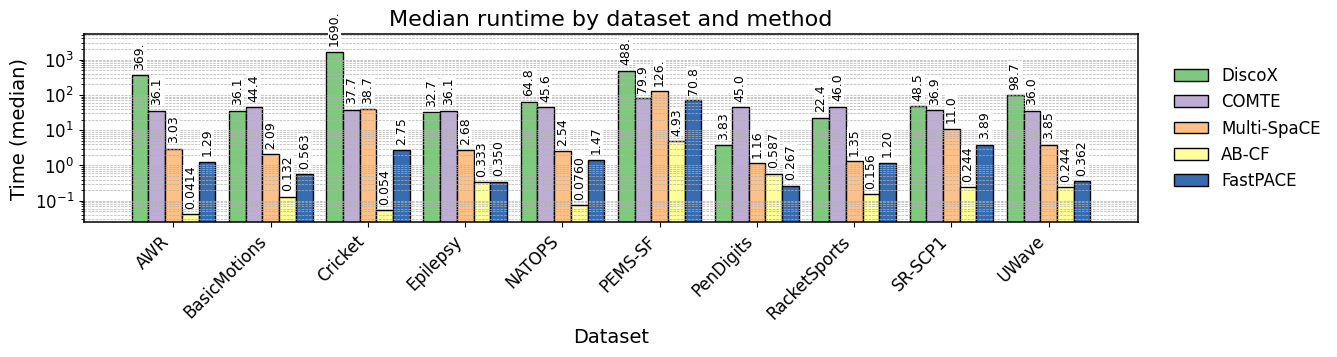

In [112]:
# Keep dataset order as it appears in the file (poster-friendly)
datasets = pd.unique(df["Dataset"].dropna())
method_order = ["DiscoX", "COMTE", "Multi-SpaCE", "AB-CF", "FastPACE"]

# Aggregate (bar heights): median runtime per (Dataset, Method)
agg = (
    df.dropna(subset=["Dataset", "Method", "times"])
      .groupby(["Dataset", "Method"], as_index=False)["times"]
      .median()
      .rename(columns={"times": "median_time"})
)

# Pivot to matrix aligned with desired orders
pivot = agg.pivot(index="Dataset", columns="Method", values="median_time").reindex(index=datasets)
pivot = pivot.reindex(columns=[m for m in method_order if m in pivot.columns])

plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
    "axes.linewidth": 1.1,
})


# Plot: wide and short figure for poster use
n_d = len(pivot.index)
n_m = len(pivot.columns)
x = np.arange(n_d)

fig, ax = plt.subplots(figsize=(16, 3.8))  # wider than tall

total_width = 0.86
bar_w = total_width / max(n_m, 1)
offsets = (np.arange(n_m) - (n_m - 1) / 2) * bar_w

bar_positions = {}


cmap = plt.get_cmap("Accent")  # or "Set2", "Dark2", "viridis", etc.
colors = {m: cmap(i) for i, m in enumerate(pivot.columns)}

for i, m in enumerate(pivot.columns):
    y = pivot[m].to_numpy(dtype=float)
    xs = x + offsets[i]
    mask = ~np.isnan(y)
    cont = ax.bar(
        xs[mask],
        y[mask],
        width=bar_w,
        label=m,
        edgecolor="black",
        linewidth=1.0,
        color=colors[m]
    )
    bar_positions[m] = (xs[mask], y[mask], cont)
    texts = ax.bar_label(cont, labels=[np.format_float_positional(v, precision=3, unique=False, fractional=False, trim='k') for v in y[mask]],
                         padding=4, fontsize=9, rotation=90, bbox=dict(facecolor="white", edgecolor="none", pad=0.2))
    for t in texts: 
        t.set_clip_on(False)

ax.set_yscale("log")
ax.set_ylim(top=ymax ** 10.0)
ax.set_xlabel("Dataset")
ax.set_ylabel("Time (median)")
ax.set_title("Median runtime by dataset and method")

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45, ha="right")

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False)
ax.grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

# Ensure room for labels
ymax = np.nanmax(pivot.to_numpy(dtype=float))
if np.isfinite(ymax) and ymax > 0:
    ax.set_ylim(top=ymax * (label_factor ** 10))

fig.tight_layout(rect=[0, 0, 0.85, 0.99])
# plt.show()
plt.savefig('./experiments/results/times_plot.PNG', dpi=300)

# Counterfactual visualization

In [202]:
import math
def plot_comp_cfs(x_orig, possible_nuns, x_cfs_dict, store=False):
    
    # Calculate auxiliary variables
    method_names = list(x_cfs_dict.keys())
    print(method_names)
    x_cfs = list(x_cfs_dict.values())
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # Define outer grid
    grid_columns = len(method_names)
    grid_rows = math.ceil(len(x_cfs) / grid_columns)
    fig = plt.figure(figsize=(12, grid_rows*2), dpi=600)
    outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0.3)

    # Iterate through outer grid plots
    for m, outer in enumerate(outer_grid):
        try:
            # Get change mask 
            method_name = method_names[m]
            x_cf = x_cfs[m]
            print(f"Method {method_name}, {x_cf.shape}")
            # Check if there is change in axis:
            if len(x_cf.shape) == 2:
                x_cf = np.expand_dims(x_cf, axis=0) 
                print(f"Expanding dimention 0: {x_cf.shape}")
            cf_length = x_cf.shape[1]
            cf_n_channels = x_cf.shape[2]
            
            if cf_length == n_channels and cf_n_channels == length:
                x_cf = np.swapaxes(x_cf, 1, 2)
                cf_length = x_cf.shape[1]
                cf_n_channels = x_cf.shape[2]
                print(f"Swap axis")
            else:
                print(x_orig.shape)
                print(x_cf.shape)
            
            """# Get nuns used by the method depending on the name
            if "gknn" in method_name:
                nun_example = possible_nuns["gknn"]
            elif "iknn" in method_name:
                nun_example = possible_nuns["iknn"]
            else:
                raise ValueError('Not detected NUN finding procedure in name. Method name must contain "gknn" or "iknn"')"""
            # found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
            proximity_values = np.abs(x_orig - x_cf)
            found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
            diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
        except IndexError:
            print("IndexError!")
            break
    
        # Create inner grid
        inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0.2, subplot_spec=outer)
        sub_channel_axs = []
        for i in range(n_channels):
            ax = plt.Subplot(fig, inner_grid[i])
            # ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
            ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
            ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.axis('off')
            # Set title if first channel
            if i == 0:
                ax.set_title(method_name)
            
            # Add fill to changes
            starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
            ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
            # Iterate over the mask segments and fill them with red color
            for i in range(0, len(starts)):
                start_idx = starts[i]
                end_idx = ends[i]
                # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
                ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            
            # Add ax to list of subplots
            fig.add_subplot(ax)
            sub_channel_axs.append(ax)

    # Plot figure
    """fig.legend(
        sub_channel_axs,     # The line objects
        labels=['x_cf', 'x_orig'],   # The labels for each line
        loc='center',
        prop={'size': 12}
    )"""
    plt.tight_layout()
    # plt.show()
    if store:
        plt.savefig(f'./experiments/results/examples_cfs_{dataset}_instance_{instance_index}.png', dpi=600)



In [245]:
dataset = 'NATOPS'
rename_method_dict = {}

aux_results_dataset = results_all_datasets_df[results_all_datasets_df["dataset"]==dataset].sort_values(by="ii")

with pd.option_context("display.max_rows", None,): 
    display(aux_results_dataset[aux_results_dataset["method"]=="Multi-SpaCE"])

,ii,nchanges,sparsity,L1,L2,proba,valid,nuns_valid,AE_OS,IF_OS,...,subsequences %,train_time,times,method,best cf index,order,fitness,nun_fitness,ImprovementOverNUN,dataset
0,0,147.0,0.120098,141.185473,14.504312,0.819910,True,True,0.915079,0.247075,...,0.016667,0,7.825817,Multi-SpaCE,6,1,-0.180756,-0.378890,0.198134,NATOPS
1,1,150.0,0.122549,118.174451,12.103382,0.884574,True,True,0.735119,0.390824,...,0.018333,0,2.538815,Multi-SpaCE,8,1,-0.138190,-0.378922,0.240732,NATOPS
2,2,73.0,0.059641,70.311717,9.274735,0.998515,True,True,0.706193,0.304865,...,0.013333,0,2.658610,Multi-SpaCE,77,1,-0.107437,-0.378892,0.271455,NATOPS
3,5,54.0,0.044118,9.288518,1.357222,0.985763,True,True,0.345933,0.084829,...,0.005000,0,2.556209,Multi-SpaCE,4,1,-0.021873,-0.378906,0.357033,NATOPS
4,9,59.0,0.048203,45.202859,7.559065,0.991994,True,True,0.671710,0.238857,...,0.006667,0,2.533486,Multi-SpaCE,2,1,-0.046291,-0.378896,0.332605,NATOPS
5,11,69.0,0.056373,102.229403,13.641712,0.713474,True,True,1.235396,0.674695,...,0.013333,0,2.558614,Multi-SpaCE,1,1,-0.134660,-0.378901,0.244242,NATOPS
6,13,144.0,0.117647,110.417008,11.381427,0.981682,True,True,0.730245,0.351477,...,0.025000,0,2.545563,Multi-SpaCE,47,1,-0.140272,-0.382986,0.242714,NATOPS
7,14,37.0,0.030229,11.558298,2.296496,0.990817,True,True,0.355658,0.205412,...,0.005000,0,2.548472,Multi-SpaCE,1,1,-0.022899,-0.383044,0.360145,NATOPS
8,15,29.0,0.023693,23.875472,5.483881,0.916978,True,True,0.432333,0.154549,...,0.005000,0,2.540660,Multi-SpaCE,6,1,-0.032614,-0.378887,0.346273,NATOPS
9,16,134.0,0.109477,126.761817,13.537637,0.906411,True,True,0.783071,0.362839,...,0.018333,0,2.517309,Multi-SpaCE,10,1,-0.139789,-0.378932,0.239143,NATOPS


In [246]:
desired_methods = ["COMTE", "AB-CF", "DiscoX", "Multi-SpaCE", "FastPACE"]
common_index_instance = 6

Sample 13: true class 4, x_orig predicted 4, desired_class  5
['COMTE', 'AB-CF', 'DiscoX', 'Multi-SpaCE', 'FastPACE']
Method COMTE, (1, 24, 51)
Swap axis


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:49: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)


Method AB-CF, (1, 24, 51)
Swap axis


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:49: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)


Method DiscoX, (1, 51, 24)
(51, 24)
(1, 51, 24)


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:49: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)


Method Multi-SpaCE, (1, 51, 24)
(51, 24)
(1, 51, 24)


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:49: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)


Method FastPACE, (1, 24, 51)
Swap axis


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:49: RuntimeWarning: divide by zero encountered in divide
  found_counterfactual_mask = (proximity_values > np.abs(x_orig)/proximity_values*0.0001).astype(int)
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_12520\3340181006.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


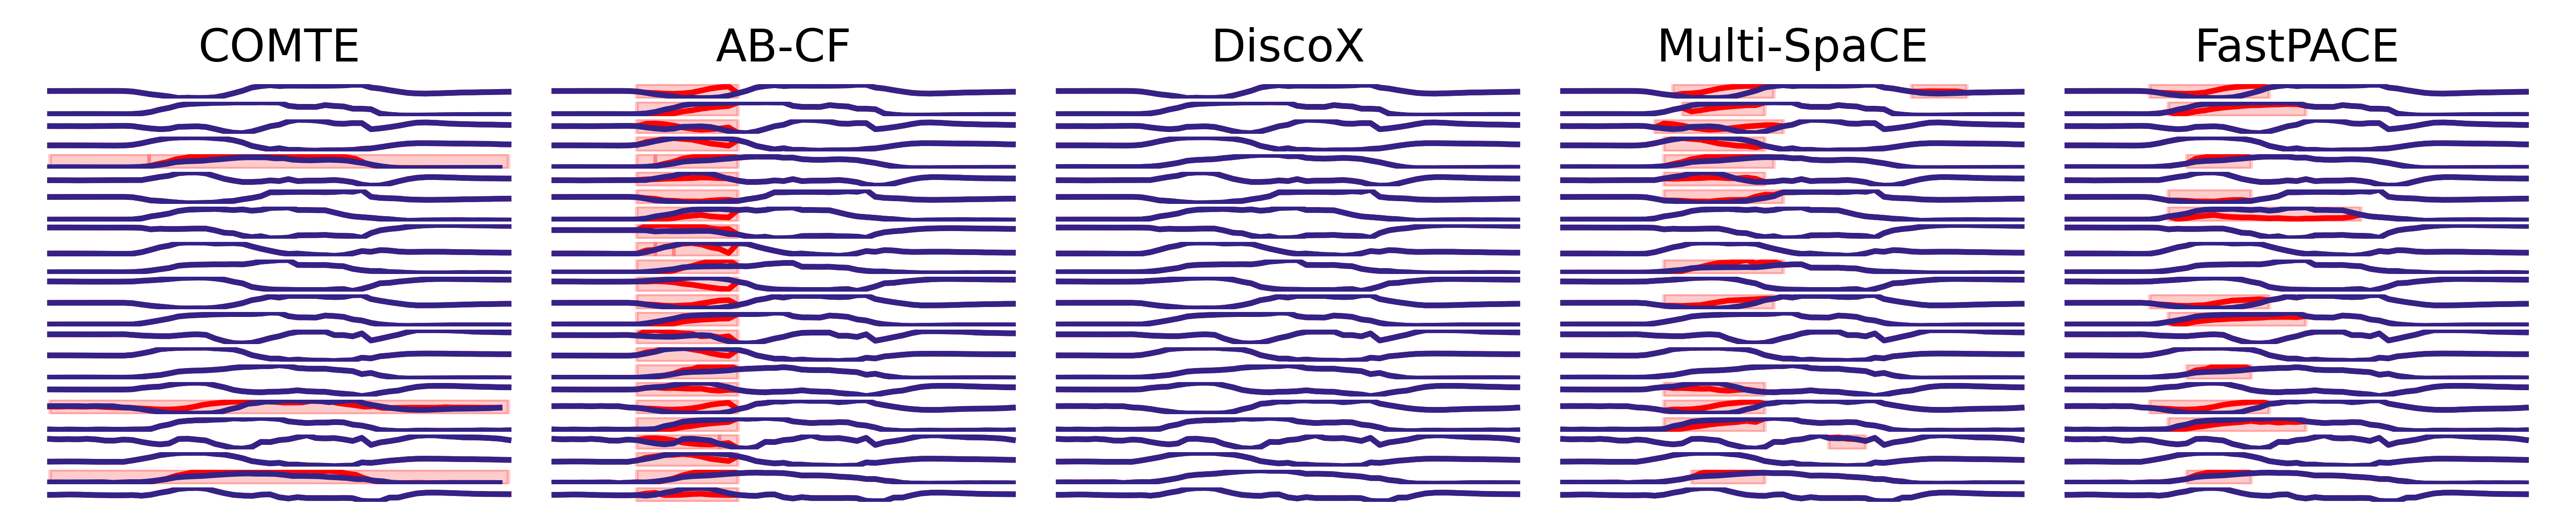

In [247]:
# Get data
X_train, y_train, X_test, y_test = data_dict[dataset]
common_indexes = common_test_indexes_dict[dataset]
instance_index = common_indexes[common_index_instance]

# Get common cfs calculated for all method
x_orig = X_test[instance_index]

# Get possible NUNs
possible_nuns = possible_nuns_dict[dataset]
possible_nuns_instance = {type: possible_nuns[type][instance_index] for type in ["gknn"]}

# Get original class and desired class
original_class = original_classes_dict[dataset][instance_index]
desired_class = desired_classes_dict[dataset][instance_index]

# Get the cf calculated for all methods
sol_cfs_methods = {}
sol_methods = methods_cfs_dict[dataset]
if desired_methods is not None:
    # sol_methods = {method: solutions for method, solutions in sol_methods.items() if method in desired_methods}
    sol_methods = {method: sol_methods[method] for method in desired_methods}

"""# Add manually DiscoX
if "DiscoX" not in sol_methods:
    DiscoX_sols = []
    for common_index in common_indexes:
        sol_dict = {}
        sol_dict["time"] = -1
        sol_dict["cf"] = np.expand_dims(X_test[common_index], axis=0)
        DiscoX_sols.append(sol_dict)
    sol_methods["DiscoX"] = DiscoX_sols"""


    
for method, solutions in sol_methods.items():
    if 'cfs' in solutions[0]:
        counterfactuals = [solution['cfs'] for solution in solutions]
    else:
        counterfactuals = [solution['cf'] for solution in solutions] 
   
    counterfactual = counterfactuals[common_index_instance]
    if len(counterfactual.shape) == 2:
        counterfactual = np.expand_dims(counterfactual, axis=0)
    
    # Extract best index solution. 
    aux_results_dataset_method = aux_results_dataset[aux_results_dataset["method"] == method]

    # Extract best counterfactual in case of multi objective
    if len(aux_results_dataset_method) > 0:
        best_cf_index = aux_results_dataset_method.iloc[common_index_instance]["best cf index"]
        best_cf = counterfactual[best_cf_index]
        best_cf = np.expand_dims(best_cf, axis=0)
    else:
        best_cf_index = 0
        best_cf = counterfactual[best_cf_index]
        best_cf = np.expand_dims(best_cf, axis=0)
        
    # Append to dictionary
    new_method_name = method
    if method in rename_method_dict:
        new_method_name = rename_method_dict[method]
    sol_cfs_methods[new_method_name] = best_cf
    
# Show result
print(f'Sample {instance_index}: true class {y_test[instance_index]}, x_orig predicted {original_class}, desired_class  {desired_class}')
plot_comp_cfs(x_orig, possible_nuns_instance, sol_cfs_methods, store=False)